In [90]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import json
import os
from functools import partial
from collections import defaultdict

In [91]:
from scipy.special import softmax as _softmax
from scipy.stats import ttest_ind, kstest

def softmax(x):
    return _softmax(x, axis=0)

def postprocess(predict):
    return np.argmax(predict, axis=0)

def _compute_volumes(mask, n_classes):
    assert len(mask.shape) == 3
    return [(mask == i).sum() for i in range(n_classes)] 

In [92]:
import torchio as tio
from mri_segmentation.data import get_data, get_test_data, get_subjects, get_sets
from mri_segmentation.utils import MRI, LABEL
from mri_segmentation.preprocessing import get_baseline_transforms
from mri_segmentation.plotting import plot_central_cuts
from mri_segmentation.utils import prepare_aseg
from sklearn.model_selection import train_test_split
from torchio import DATA

In [93]:
root = Path('/nmnt/x2-hdd/experiments/pulmonary_trunk/test/')

In [94]:
def get_fcd_dset():
    root = Path('/nmnt/x2-hdd/experiments/pulmonary_trunk/test/')
    data_dir = root / 'fcd'
    labels_path = root / 'targets_fcd_bank.csv'

    distmaps_dir = None
    n_classes = 6
    key = 'patient'

    data_list = get_data(data_dir, labels_path, key, distmaps_dir=distmaps_dir, n_classes=n_classes)
    subjects = get_subjects(data_list['norm'], data_list['aseg'])
    _, transform = get_baseline_transforms(n_classes)
    data_set = tio.SubjectsDataset(subjects, transform=transform)
    
    return data_set

def get_anat_dset(val=True):
    n_classes = 6
    key = 'Subject'

    data_dir = Path('/nmnt/x2-hdd/experiments/pulmonary_trunk/test/anat-20210925T153621Z-001/')
    train_data_dir = data_dir / 'anat' / 'fs_segmentation'
    test_data_dir = data_dir / 'test'
    labels_path = data_dir / 'anat' / 'unrestricted_hcp_freesurfer.csv'
    distmaps_dir = None

    _, transform = get_baseline_transforms(n_classes)
    train_data_list = get_data(train_data_dir, labels_path, key, distmaps_dir=distmaps_dir, n_classes=n_classes)
    test_data_list = get_test_data(test_data_dir, key)
    train_subjects = get_subjects(train_data_list['norm'], train_data_list['aseg'])
    test_subjects = get_subjects(test_data_list['norm'], test_data_list['aseg'])
    train_set, val_set, test_set = get_sets(train_subjects, test_subjects, transforms=(transform, transform))
    
    return val_set if val else train_set

In [95]:
def compute_volumes(data_set, predictions_dir, n_classes=6):
    target_volumes, pred_volumes, target_uids, pred_uids = [], [], [], []

    for sample in tqdm(data_set):
        target_mask = torch.argmax(sample[LABEL][DATA], dim=0)
        uid = sample[MRI]['path'].split('/')[-1][:-7]
        
        if f'{uid}' in list(map(str, map(lambda x: x.stem, predictions_dir.iterdir()))):
            pred_mask = postprocess(np.load(predictions_dir / f'{uid}.npy'))
            pred_volumes.append(_compute_volumes(pred_mask, n_classes))
            pred_uids.append(uid)

        target_volumes.append(_compute_volumes(target_mask, n_classes))
        target_uids.append(uid)


    columns = ['OTHER', 'VENTRCL', 'BRN_STEM', 'HIPPOCMPS', 'AMYGDL', 'GM']
    df_target = pd.DataFrame(np.array(target_volumes), target_uids, columns)
    df_pred = pd.DataFrame(np.array(pred_volumes), pred_uids, columns)
    
    return df_pred, df_target

## Compare volumes of brain parts

In [96]:
def _format(s):
    s = s[:-5]
    if s.startswith('gueht_fsdocker_'):
        s = s[15:]
    elif s.startswith('kulakov_input_'):
        s = s[14:]
    elif s == 'Gueht_fs_preproc_T091':
        s = 'T091'
    elif s == 'Gueht_Test_freesurfer_101019_T003_orig':
        s = 'T003'
    elif s.startswith('Gueht_Test_freesurfer_101019_'):
        s = s[29:]
    elif s.startswith('Gueht_Test_p2_fspreproc_'):
        s = s[24:]
    elif s.startswith('fcd') or s.startswith('no_fcd'):
        pass
    else:
        raise ValueError(f'Failed to parse string "{s}"')
    
    return s

In [ ]:
train_set_anat = get_anat_dset(False)

def _compute_volumes(mask, n_classes):
    assert len(mask.shape) == 3
    return [(mask == i).sum().item() for i in range(n_classes)]

for sample in tqdm(train_set_anat):
    target_mask = sample[LABEL][DATA].argmax(dim=0)
    uid = sample[MRI]['path'].split('/')[-1][:-7]
    with open(root / 'anat_volumes' / f'{uid}.json', 'wt') as f:
        json.dump(_compute_volumes(target_mask, 6), f)

In [97]:
cols = ['VENTRCL', 'BRN_STEM', 'HIPPOCMPS', 'AMYGDL', 'GM', 'OTHER']

def load_volumes(root, format_=True):
    volumes = []
    for name in os.listdir(root):
        with open(root / name, 'rt') as f:
            volumes.append({'patient': name[:-5], **dict(list(zip(cols, json.load(f))))})

    volumes = pd.DataFrame(volumes)
    if format_:
        volumes['patient'] = volumes['patient'].apply(_format)
    volumes = volumes.astype({'patient': 'string'})
    return volumes

df_pred_fcd = load_volumes(root / 'compute_fcd' / 'volumes_pred').astype({'patient': 'string'})
df_target_fcd = load_volumes(root / 'compute_fcd' / 'volumes_gt').astype({'patient': 'string'})
df_target_anat = load_volumes(root / 'anat_volumes', format_=False).astype({'patient': 'string'})

In [98]:
df_label_fcd = pd.read_csv(root / 'targets_fcd_bank.csv')
df_label_fcd = df_label_fcd.astype({'patient': 'string'})

In [99]:
df_pred_fcd = df_pred_fcd.merge(df_label_fcd, how='inner', on='patient', suffixes=('', '_r'))
df_target_fcd = df_target_fcd.merge(df_label_fcd, how='inner', on='patient', suffixes=('', '_r'))
# df_target_anat = format_df(df_target_fcd)

In [100]:
df_target_anat['fcd'] = 0
df_target = pd.concat([df_target_fcd, df_target_anat], axis=0)

In [101]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

cols = ['VENTRCL', 'BRN_STEM', 'HIPPOCMPS', 'AMYGDL', 'GM', 'OTHER']

In [115]:
def plt_routine(suptitle, x1, x2, label1, label2):
    fig = plt.figure(figsize=(10,10))
    fig.tight_layout()
    plt.suptitle(suptitle, fontsize=25)
    for i, col in enumerate(cols):
        plt.subplot(3, 2, i + 1)
        if i > 0:
            x_fmt = lambda x, pos: '{:.1f}'.format(x / 1e3, pos)
            plt.gca().xaxis.set_major_formatter(FuncFormatter(x_fmt))
        if i in [1, 2, 3, 4]:
            y_fmt = lambda x, pos: '{:.2f}'.format(x * 1e3, pos)
            plt.gca().yaxis.set_major_formatter(FuncFormatter(y_fmt))

        m1 = x1[col].mean()
        m2 = x2[col].mean()
        plt.axvline(m1, c='r')
        plt.axvline(m2, c='r')
        # two-tail alternative welch test for volumes means
        _, p_welch = ttest_ind(x1[col], x2[col], equal_var=False)
        _, p_kolm = kstest(x1[col], x2[col])
        plt.hist(x1[col], color='g', label=label1, bins=50, alpha=0.5, density=True);
        plt.hist(x2[col], color='b', label=label2, bins=30, alpha=0.5, density=True);
        plt.xlabel('cm^3') if i > 0 else plt.xlabel('mm^3')
        plt.legend()
        plt.title(col + f' diff:{round(abs(m1-m2)*1e-3,2)}cm^3, \n p_welch: {round(p_welch, 3)}, p_kolm: {round(p_kolm, 3)}');
    
    fig.tight_layout()

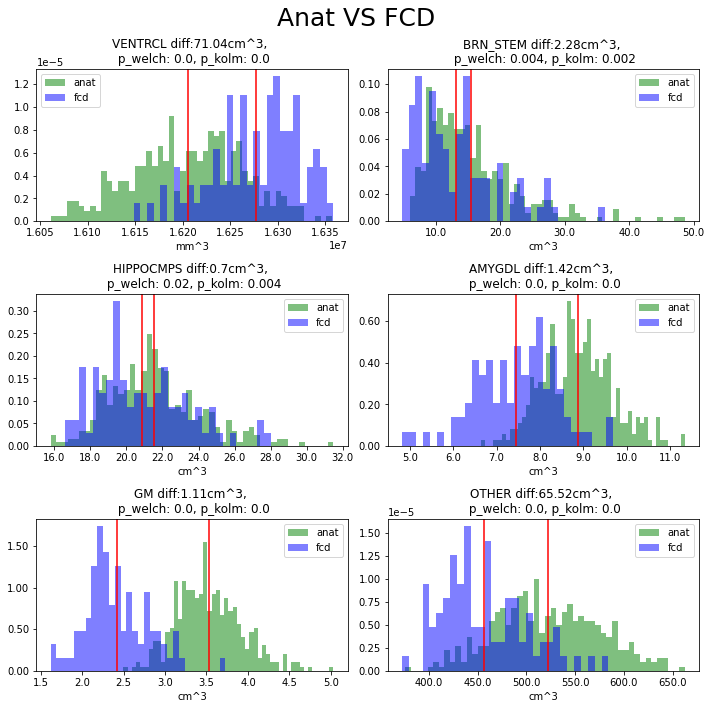

In [116]:
plt_routine('Anat VS FCD', df_target_anat, df_pred_fcd[df_pred_fcd['fcd'] == 0], 'anat', 'fcd')

Distributuions of different brain region volumes for healthy people differs a lot in HPC and FCD datasets.

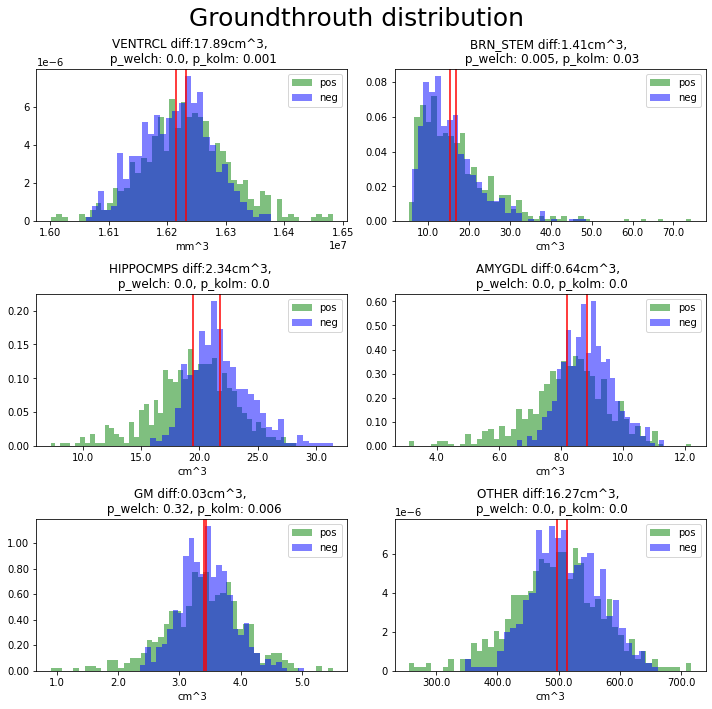

In [117]:
plt_routine('Groundthrouth distribution', df_target[df_target['fcd'] == 1], \
            df_target[df_target['fcd'] == 0], 'pos', 'neg')

Brain stem and gray matter are most similar regions in terms of volumes (gray matter actually same) for healty and non-healthy subjects.

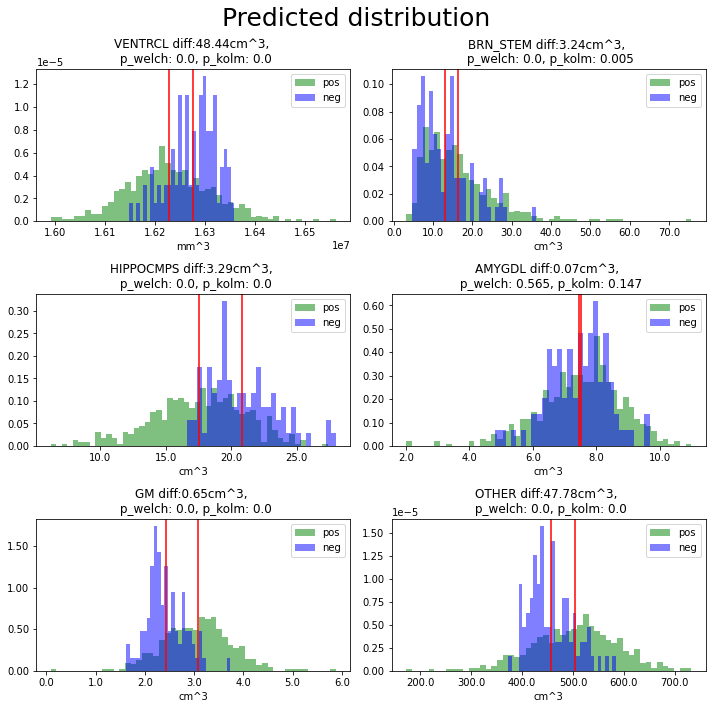

In [118]:
plt_routine('Predicted distribution', df_pred_fcd[df_pred_fcd['fcd'] == 1], \
            df_pred_fcd[df_pred_fcd['fcd'] == 0], 'pos', 'neg')

Network volume distributions looks more or less the same as groundtruth but tests results are opposite for amygdala, brain stem and gray matter.

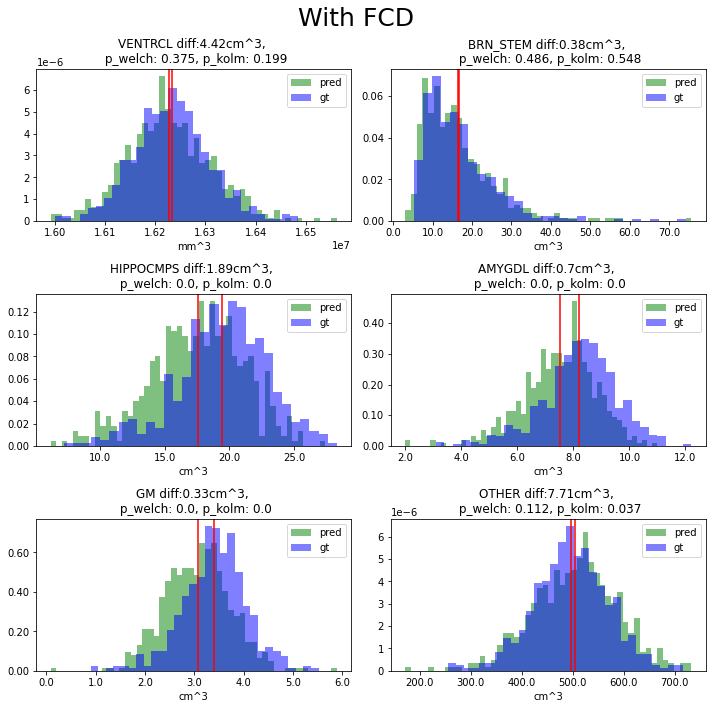

In [119]:
plt_routine('With FCD', df_pred_fcd[df_pred_fcd['fcd'] == 1], \
            df_target[df_target['fcd'] == 1], 'pred', 'gt')

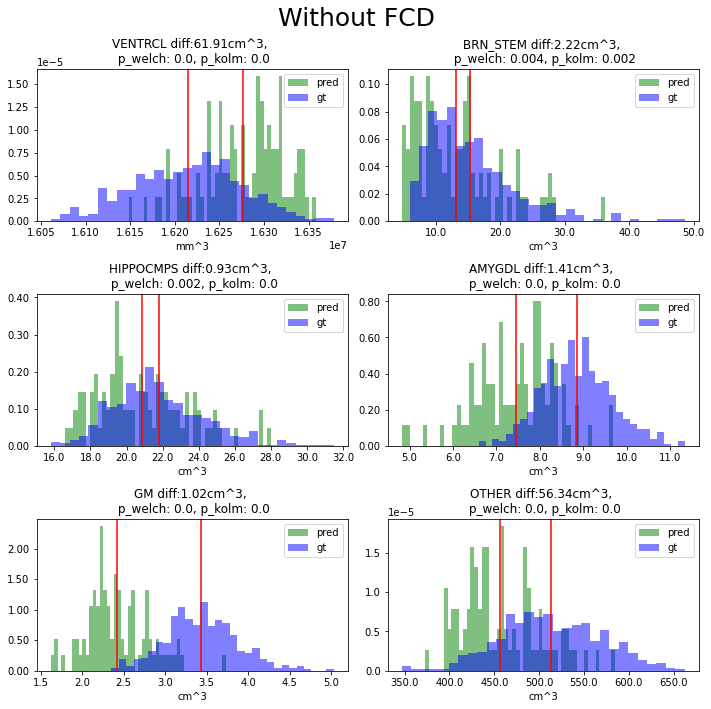

In [120]:
plt_routine('Without FCD', df_pred_fcd[df_pred_fcd['fcd'] == 0], \
            df_target[df_target['fcd'] == 0], 'pred', 'gt')

There are fidderences in almost all volumes distributions (based on freesurfer results), but distributions overlap signifantly.

## Performace drop

In [41]:
import re

def _inv_format(s):
    if re.match(r'P[0-9][0-9][0-9]', s):
        s = f'gueht_fsdocker_{s}' 
    elif re.match(r'G[0-9][0-9][0-9]', s):
        s = f'kulakov_input_{s}'
    elif s == 'T091':
        s = 'Gueht_fs_preproc_T091'
    elif s == 'T003':
        s = 'Gueht_Test_freesurfer_101019_T003_orig'
    elif re.match(r'T[0-9][0-9][0-9]', s) and int(s[1:]) <= 38:
        s = f'Gueht_Test_freesurfer_101019_{s}'
    elif re.match(r'T[0-9][0-9][0-9]', s) and int(s[1:]) >= 39: 
        s = f'Gueht_Test_p2_fspreproc_{s}'
    elif s.startswith('fcd') or s.startswith('no_fcd'):
        pass
    else:
        s = 'None'
    
    return s
        
def inv_format_df(df):
    df['filename'] = df['patient'].apply(_inv_format)
    return df

In [42]:
df_label_fcd = inv_format_df(df_label_fcd)
df_fcd_1 = df_label_fcd[(df_label_fcd['fcd'] == 1) & (df_label_fcd['filename'] != 'None')]
df_fcd_0 = df_label_fcd[(df_label_fcd['fcd'] == 0) & (df_label_fcd['filename'] != 'None')]

In [276]:
files_dir = Path('/nmnt/x2-hdd/experiments/pulmonary_trunk/test/fcd')

fcd_1_files = list(map(str, map(lambda x: x.stem, files_dir.iterdir())))
fcd_1 = []

for stem in df_fcd_1['filename']:
    if f'{stem}_norm.nii' in with_fcd_files_ and f'{stem}_aparc+aseg.nii' in fcd_1_files:
        fcd_1.append(f'{stem}_norm.nii.gz')
        fcd_1.append(f'{stem}_aparc+aseg.nii.gz')

In [277]:
fcd_0_files = list(map(str, map(lambda x: x.stem, files_dir.iterdir())))
fcd_0 = []

for stem in df_fcd_0['filename']:
    if f'{stem}_norm.nii' in without_fcd_files_ and f'{stem}_aparc+aseg.nii' in fcd_0_files:
        fcd_0.append(f'{stem}_norm.nii.gz')
        fcd_0.append(f'{stem}_aparc+aseg.nii.gz')

In [279]:
import json

with open(root / 'fcd_0.json', 'wt') as f:
    json.dump(fcd_0, f)

with open(root / 'fcd_1.json', 'wt') as f:
    json.dump(fcd_1, f)

### Calc metrics

In [9]:
from mri_segmentation.metrics import dice_score, hausdorff_score

def _compute_metrics(pred, target):
    n_classes = 6
    spacing = (1., 1., 1.)
    scores = defaultdict(list)
    metrics = {
        **{f'dice_{i}': partial(dice_score, n_classes=n_classes, channel=i) for i in range(n_classes)},
        **{f'hausdorff_{i}': partial(hausdorff_score, spacing=spacing, channel=i) for i in range(n_classes)}
    }

    dice_scores = []
    for name, metric in metrics.items():
        scores[name].append(metric(pred, target))
        if 'dice' in name:
            dice_scores.append(scores[name][-1])

    scores['dice'].append(np.mean(dice_scores))

    return dict(scores)
 

def compute_metrics(data_set, predictions_dir, save_dir, n_classes=6):
    for sample in tqdm(data_set):
        target_mask = sample[LABEL][DATA].unsqueeze(0)
        uid = sample[MRI]['path'].split('/')[-1][:-7]
        
        if f'{uid}' in list(map(str, map(lambda x: x.stem, predictions_dir.iterdir()))):
            pred_mask = torch.from_numpy(np.load(predictions_dir / f'{uid}.npy')).unsqueeze(0)
            metrics = _compute_metrics(pred_mask, target_mask)
    
            with open(save_dir / f'{uid}.json', 'wt') as f:
                json.dump(metrics, f)

In [ ]:
from mri_segmentation.data import get_data, get_subjects
from mri_segmentation.preprocessing import get_baseline_transforms
import torchio as tio

key = 'patient'
data_dir = root / 'fcd'
labels_path = root / 'targets_fcd_bank.csv'
distmaps_dir = None
n_classes = 6
predictions_dir_fcd = root / 'predictions' / 'fcd'
_, transform = get_baseline_transforms(n_classes)

names_dict = {
    'with_fcd': root / 'fcd_1.json',
    'without_fcd': root / 'fcd_0.json'
}

for group, path2names in names_dict.items():
    with open(path2names, 'rt') as f:
        names = json.load(f)

    data_list = get_data(data_dir, labels_path, key, distmaps_dir=distmaps_dir, n_classes=n_classes, names=names)
    subjects = get_subjects(data_list['norm'], data_list['aseg'])
    data_set = tio.SubjectsDataset(subjects, transform=transform)
    
    compute_metrics(data_set, predictions_dir_fcd, root / 'metrics_repeat' / group)

In [23]:
from mri_segmentation.data import get_data, get_subjects
from mri_segmentation.preprocessing import get_baseline_transforms
import torchio as tio

key = 'patient'
data_dir = root / 'fcd'
labels_path = root / 'targets_fcd_bank.csv'
distmaps_dir = None
n_classes = 6
predictions_dir_fcd = root / 'predictions' / 'fcd'
_, transform = get_baseline_transforms(n_classes)

names_dict = {
    'with_fcd': root / 'fcd_1.json',
    'without_fcd': root / 'fcd_0.json'
}

for group, path2names in names_dict.items():
    with open(path2names, 'rt') as f:
        names = json.load(f)

    data_list = get_data(data_dir, labels_path, key, distmaps_dir=distmaps_dir, n_classes=n_classes, names=names)
    subjects = get_subjects(data_list['norm'], data_list['aseg'])
    data_set = tio.SubjectsDataset(subjects, transform=transform)
    
    compute_metrics(data_set, predictions_dir_fcd, root / 'metrics' / group)

100%|██████████| 90/90 [36:22<00:00, 24.25s/it]


In [43]:
def load_metrics(root, format_=True):
    metrics = []
    for name in os.listdir(root):
        with open(root / name, 'rt') as f:
            metrics.append({'patient': name[:-5], **json.load(f)})

    metrics = pd.DataFrame(metrics)
    if format_:
        metrics['patient'] = metrics['patient'].apply(_format)
    metrics = metrics.astype({'patient': 'string'})
    
    return metrics

metrics = load_metrics(root / 'compute_fcd' / 'metrics')

In [122]:
metrics = metrics.merge(df_label_fcd, how='inner', on='patient', suffixes=('', '_r'))

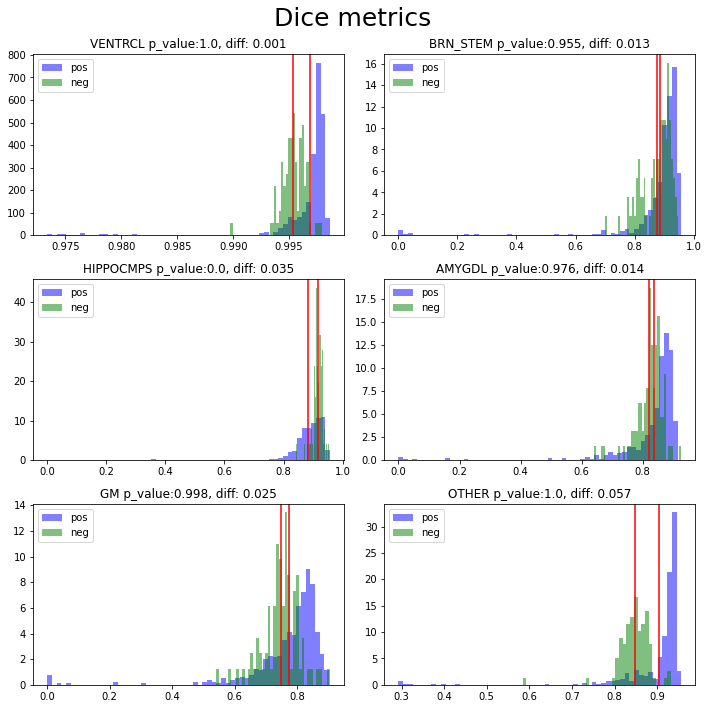

In [123]:
fig = plt.figure(figsize=(10,10))
plt.suptitle('Dice metrics', fontsize=25)
names = ['VENTRCL', 'BRN_STEM', 'HIPPOCMPS', 'AMYGDL', 'GM', 'OTHER']
cols = [f'dice_{i}' for i in range(6)]

for i, col in enumerate(cols):
    plt.subplot(3, 2, i + 1)
    x1 = metrics[col][metrics['fcd'] == 1]
    x2 = metrics[col][metrics['fcd'] == 0]
    # we suppose than on fcd data network will fail
    _, p_val = ttest_ind(x1, x2, alternative='less', equal_var=False)
    m1, m2 = x1.mean(), x2.mean()
    plt.axvline(m1, c='r')
    plt.axvline(m2, c='r')
    plt.hist(x1, label='pos', color='b', bins=60, alpha=0.5, density=True);
    plt.hist(x2, label='neg', color='g', bins=40, alpha=0.5, density=True);
    plt.legend()
    plt.title(f'{names[i % 6]} p_value:{round(p_val, 3)}, diff: {round(abs(m1 - m2), 3)}');

fig.tight_layout()

For all labels except hippocampus network unexpectedly perform statically better on average, than on healthy data; hovewer diffs are quite small.

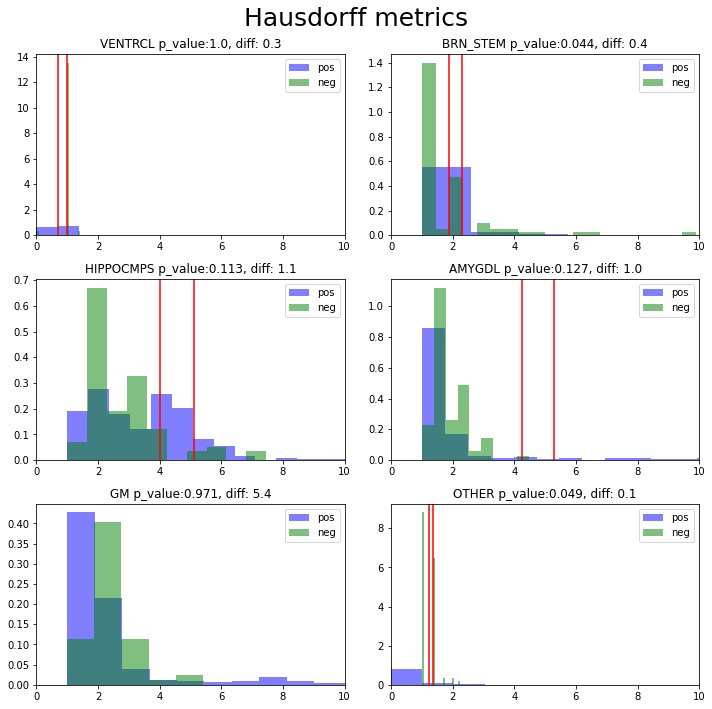

In [132]:
fig = plt.figure(figsize=(10,10))
plt.suptitle('Hausdorff metrics', fontsize=25)
cols = [f'hausdorff_{i}' for i in range(6)]

for i, col in enumerate(cols[:6]):
    plt.subplot(3, 2, i + 1)
    x1 = metrics[col][metrics['fcd'] == 1]
    x2 = metrics[col][metrics['fcd'] == 0]
    # we suppose than on fcd data network will fail
    _, p_val = ttest_ind(x1, x2, alternative='greater', equal_var=False)
    m1, m2 = x1.mean(), x2.mean()
    plt.xlim(right=10)
    plt.axvline(m1, c='r')
    plt.axvline(m2, c='r')
    bins = 90 if i in [2, 3, 4] else 20
    plt.hist(x1, label='pos', color='b', bins=bins, alpha=0.5, density=True);
    plt.hist(x2, label='neg', color='g', bins=bins, alpha=0.5, density=True);
    plt.legend()
    plt.title(f'{names[i % 6]} p_value:{round(p_val, 3)}, diff: {round(abs(m1 - m2), 1)}');

fig.tight_layout()

For all labels except brain stem and "other" network unexpectedly perform statically better on average, than on healthy data; hovewer hausdorff metrics have long tails.

In [147]:
res = {
    'dice_0': [0.9987389445304871, 0.9988491535186768, 0.9986804127693176], 
    'dice_1': [0.9352140426635742, 0.9310075640678406, 0.9440145492553711], 
    'dice_2': [0.9584661722183228, 0.9531077146530151, 0.9575520753860474], 
    'dice_3': [0.942785382270813, 0.9330844879150391, 0.9273626804351807], 
    'dice_4': [0.9270209670066833, 0.923873782157898, 0.9167892932891846], 
    'dice_5': [0.9698624014854431, 0.9650875926017761, 0.9642024040222168],
    'hausdorff_0': [0.0, 0.0, 0.0],
    'hausdorff_1': [1.0, 1.0, 1.0],
    'hausdorff_2': [1.4142135623730951, 2.0, 2.23606797749979],
    'hausdorff_3': [1.0, 1.0, 1.0],
    'hausdorff_4': [1.0, 1.0, 1.0], 
    'hausdorff_5': [0.0, 1.0, 1.0], 
}

df = pd.concat([
    metrics[cols][metrics['fcd'] == 0].mean(axis=0),
    metrics[cols][metrics['fcd'] == 1].mean(axis=0),
    pd.DataFrame(res).mean(axis=0)
], axis=1).T
df.index = ['fcd_neg', 'fcd_pos', 'anat']


In [164]:
df.round(2)

,dice_0,dice_1,dice_2,dice_3,dice_4,dice_5,hausdorff_0,hausdorff_1,hausdorff_2,hausdorff_3,hausdorff_4,hausdorff_5
fcd_neg,1.0,0.87,0.92,0.82,0.75,0.85,0.99,1.89,4.02,4.26,20.90,1.22
fcd_pos,1.0,0.89,0.88,0.84,0.77,0.90,0.71,2.29,5.10,5.30,15.51,1.35
anat,1.0,0.94,0.96,0.93,0.92,0.97,0.00,1.00,1.88,1.00,1.00,0.67


In [163]:
df_mean = pd.concat([
    df.iloc[:, :5].mean(axis=1),
    df.iloc[:, 5:].mean(axis=1)
], axis=1)
df_mean.columns = ['dice', 'hausdorff']
df_mean.round(2)

,dice,hausdorff
fcd_neg,0.87,4.88
fcd_pos,0.87,4.45
anat,0.95,0.93


On average network perform comparable on both health and non-health data, with big drop compared to HPC dataset. Most probably because of domain shift (1.5T-scans, children scans and so on).

### Look at predictions

We take median predictions

In [170]:
print(metrics[['patient', 'dice']][metrics['fcd'] == 0].sort_values('dice')['patient'].iloc[45])
print(metrics[['patient', 'dice']][metrics['fcd'] == 1].sort_values('dice')['patient'].iloc[531 // 2])

T051
G519


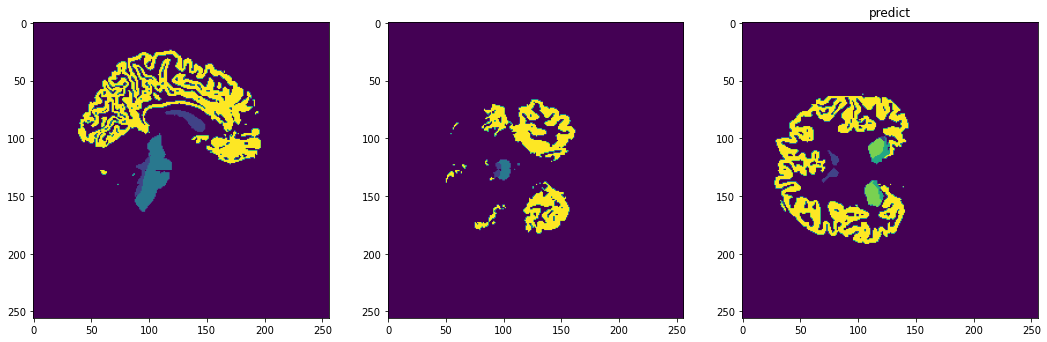

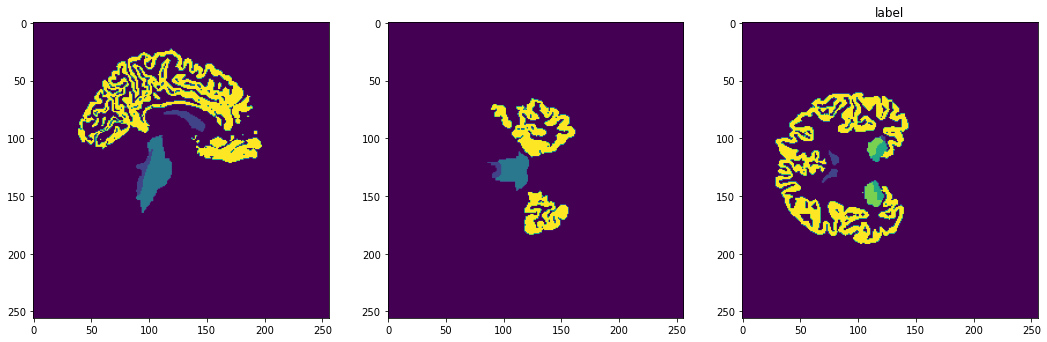

In [10]:
pred_dir = root / 'predictions' / 'fcd'
name = 'kulakov_input_G519'
pred = np.argmax(np.load(pred_dir / f'{name}_norm.npy'), axis=0)
target = tio.Image(root / 'fcd' / f'{name}_aparc+aseg.nii.gz', tio.LABEL).tensor.squeeze(0).numpy()
plot_central_cuts(pred, title='predict')
plot_central_cuts(prepare_aseg(torch.tensor(target)).numpy(), 'label')

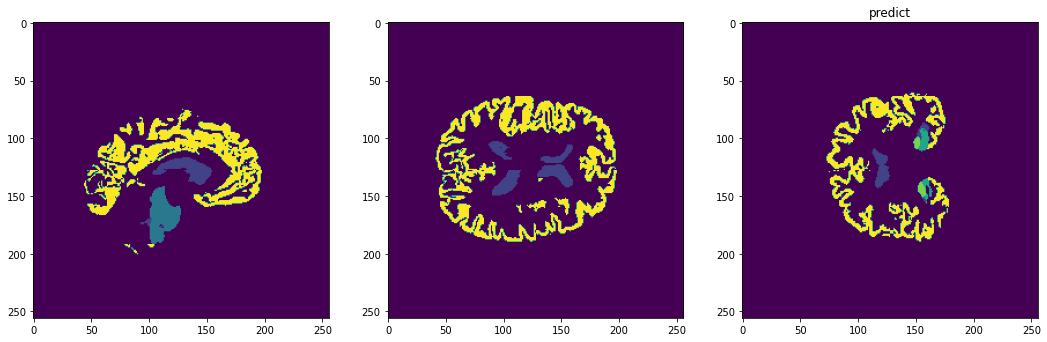

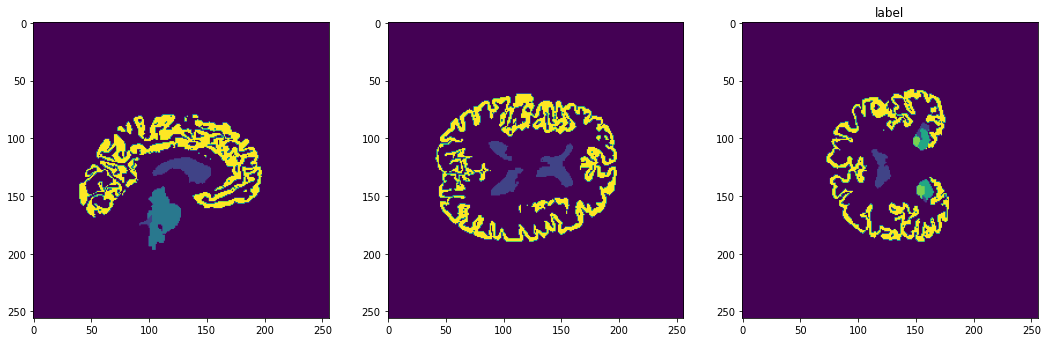

In [11]:
name = 'Gueht_Test_p2_fspreproc_T051'
pred = np.argmax(np.load(pred_dir / f'{name}_norm.npy'), axis=0)
target = tio.Image(root / 'fcd' / f'{name}_aparc+aseg.nii.gz', tio.LABEL).tensor.squeeze(0).numpy()
plot_central_cuts(pred, title='predict')
plot_central_cuts(prepare_aseg(torch.tensor(target)).numpy(), 'label')

Prediction on brain with disease better than on health perceptually.

## Split data for autoencoder

Since we want to use stacking (segmentation -> encoder -> classifier) to classify disease we need properly split data, taking into account disbalance in data (fcd dset contatin only 90 healthy subjects).

In [50]:
import json
import random

with open(root / 'fcd_0.json', 'rt') as f:
    fcd_0 = json.load(f)

with open(root / 'fcd_1.json', 'rt') as f:
    fcd_1 = json.load(f)

a_fcd_1 = random.sample(fcd_1, len(fcd_1) // 2)
a_fcd_0 = random.sample(fcd_0, len(fcd_0) // 2)
c_fcd_1 = [x for x in fcd_1 if x not in a_fcd_1]
c_fcd_0 = [x for x in fcd_0 if x not in a_fcd_0]

c_train = [
    *random.sample(c_fcd_1, int(len(c_fcd_1) * 0.85)),
    *random.sample(c_fcd_0, int(len(c_fcd_0) * 0.85))
]
c_test = [x for x in [*c_fcd_1, *c_fcd_0] if x not in c_train]

a_train = [
    *random.sample(a_fcd_1, int(len(a_fcd_1) * 0.85)),
    *random.sample(a_fcd_0, int(len(a_fcd_0) * 0.85))
]
a_test = [x for x in [*a_fcd_1, *a_fcd_0] if x not in a_train]


with open(root / 'autoencoder' / 'test.json', 'wt') as f:
    json.dump(a_test, f)

with open(root / 'autoencoder' / 'train.json', 'wt') as f:
    json.dump(a_train, f)
    
with open(root / 'classifier' / 'test.json', 'wt') as f:
    json.dump(c_test, f)

with open(root / 'classifier' / 'train.json', 'wt') as f:
    json.dump(c_train, f)

## Autoencoder predictions

### Cross entropy loss 5 epochs

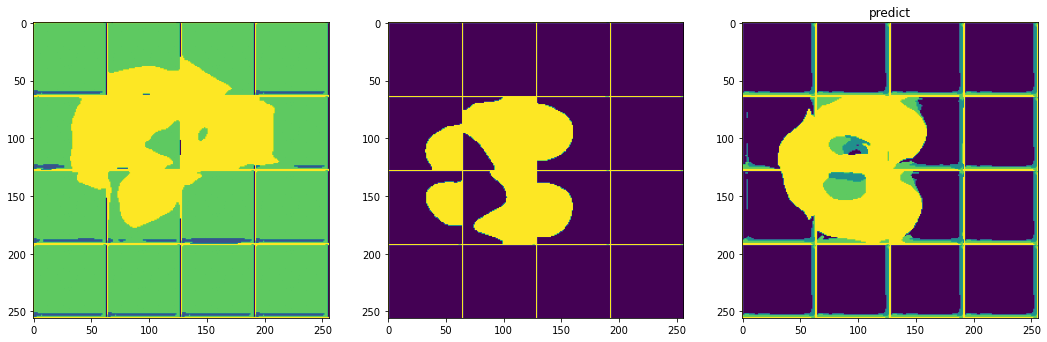

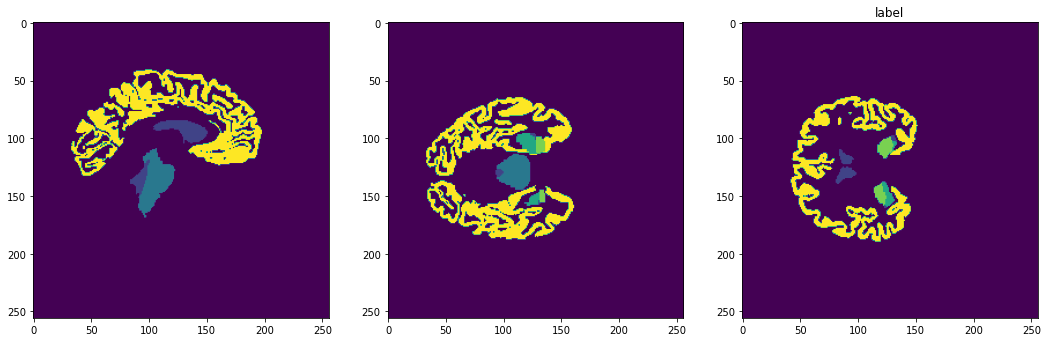

In [13]:
name = 'kulakov_input_G232'

pred_dir = root / 'predictions' / 'fcd'
pred = np.argmax(np.load(root / 'predictions' / 'autoencoder' / f'{name}_aparc+aseg.npy'), axis=0)
target = tio.Image(root / 'fcd' / f'{name}_aparc+aseg.nii.gz', tio.LABEL).tensor.squeeze(0).numpy()
plot_central_cuts(pred, title='predict')
plot_central_cuts(prepare_aseg(torch.tensor(target)).numpy(), 'label')

Strange artifacts. Looks like an error in patches splitting-aggregation procedure

### Dice loss 5 epochs

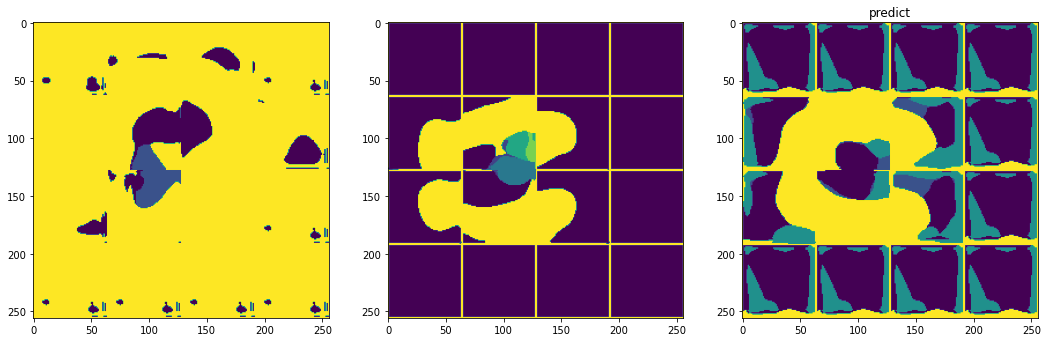

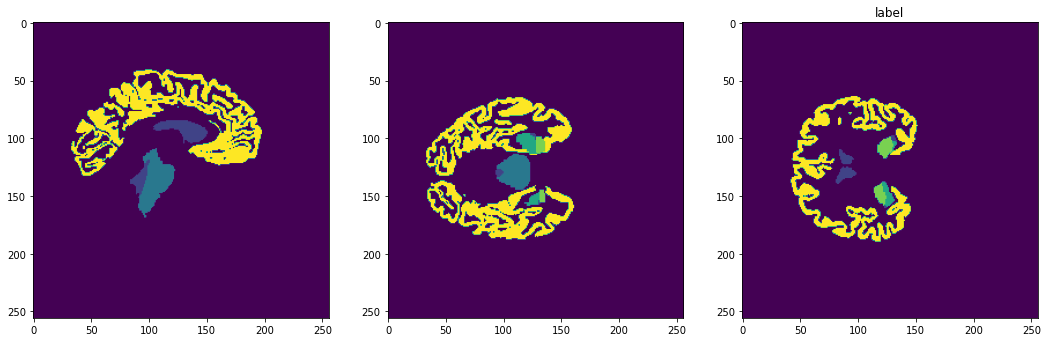

In [11]:
name = 'kulakov_input_G232'

pred_dir = root / 'predictions' / 'fcd'
pred = np.argmax(np.load(root / 'predictions' / 'autoencoder_dice' / f'{name}_aparc+aseg.npy'), axis=0)
target = tio.Image(root / 'fcd' / f'{name}_aparc+aseg.nii.gz', tio.LABEL).tensor.squeeze(0).numpy()
plot_central_cuts(pred, title='predict')
plot_central_cuts(prepare_aseg(torch.tensor(target)).numpy(), 'label')

This is looks even bad.